<a href="https://colab.research.google.com/github/manhnguyen48/fraud_creditcard/blob/master/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading and importing data

In [0]:
%%capture
!pip install numpy==1.15.4
!pip install pandas==0.23.4
!pip install matplotlib
!pip install seaborn==0.9.0
!pip install kaggle
!pip install xgboost==0.81.0
!pip install scikit-plot
!pip install shap


#Restarting runtime to load the new packages
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ethannguyen48","key":"5c21707bf21c4b216010910145c0c654"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals.joblib import parallel_backend

%matplotlib inline 
warnings.filterwarnings('ignore')

In [0]:
df_raw = pd.read_csv('creditcardfraud.zip', compression='zip')


# Overview of dataset

In [6]:
display(df_raw.head())
display(df_raw.describe())
display(df_raw.info())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

None

# Target variable distribution

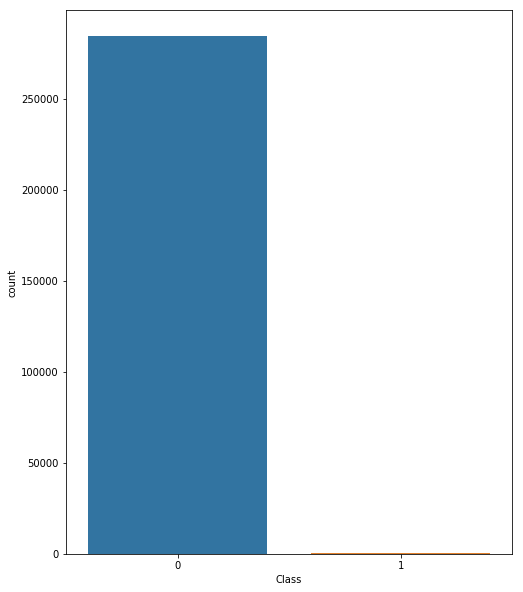

0    284315
1       492
Name: Class, dtype: int64

In [7]:
plt.figure(figsize=(8,10))
sns.countplot(data=df_raw, x='Class')
plt.show()
display(df_raw.Class.value_counts())

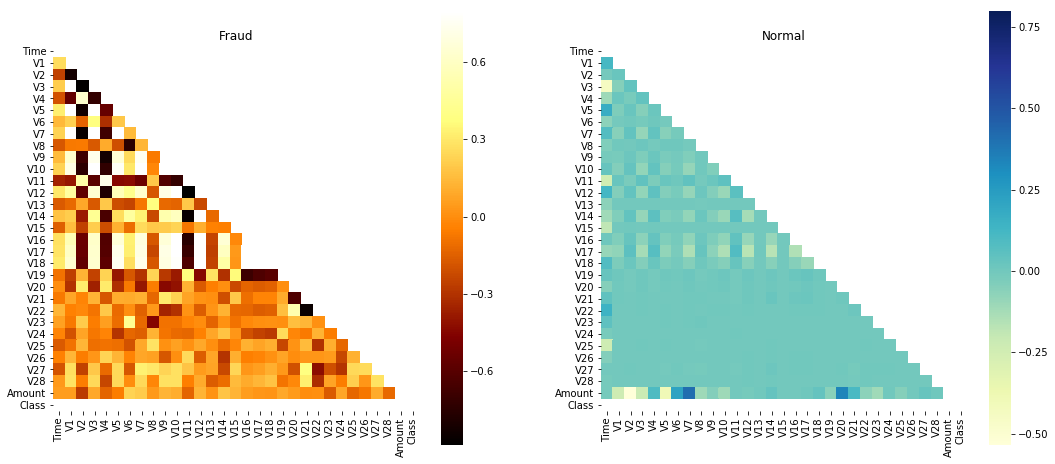

In [8]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 18, 8))
corr = df_raw.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((df_raw.loc[df_raw['Class'] ==1]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'afmhot', mask=mask);
ax1.set_title('Fraud')
sns.heatmap((df_raw.loc[df_raw['Class'] ==0]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask);
ax2.set_title('Normal')
plt.show()

# Choosing parameters

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

def INPUT_FUNC(df):
  df['Norm_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
  df_transformed = df.drop(['Amount','Time'],axis=1)  
  return df_transformed

def X_Y_split(df, seed=42):
  y = np.array(df.Class.tolist())
  dfx = df.drop('Class', axis=1)
  X = np.array(dfx.values)
  
  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed, 
                                                      test_size = 0.20, stratify = y)
  
  return X_train, X_test, y_train, y_test

In [0]:
df_transformed = INPUT_FUNC(df_raw)
X_train, X_test, y_train, y_test = X_Y_split(df_transformed)

In [0]:
params_dist = {
    'max_depth':range(5,15,2),
    'min_child_weight':range(1,6,2),
    'gamma': [i/10.0 for i in range(0,5)],
    'colsample_bytree': np.linspace(0.1,0.5,5), 
    'subsample':np.linspace(0.2,0.9,5),
    'reg_alpha':[0.1, 1, 10,100],
    'learning_rate': np.linspace(0.05,0.3,6),
    'n_estimators': [500]
    }

model = xgb.XGBClassifier(objective='binary:logistic',
                          tree_method='gpu_exact')


model_cv = RandomizedSearchCV(model, params_dist, n_jobs=-1,cv=5, 
                           n_iter=10,
                        scoring='f1_weighted')

In [12]:
%%time
with parallel_backend('threading'):
    model_cv.fit(X_train, y_train)

CPU times: user 31min 11s, sys: 16min 27s, total: 47min 38s
Wall time: 45min 20s


In [13]:
model_cv.best_params_

{'colsample_bytree': 0.1,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 500,
 'reg_alpha': 0.1,
 'subsample': 0.55}

# Modelling

In [14]:
%%time

d_train = xgb.DMatrix(data=X_train, label=y_train, nthread=-1)
d_test = xgb.DMatrix(data=X_test, label=y_test,nthread=-1)

watch_list = {(d_test, 'eval'), (d_train, 'train')}

param_set = {'objective':'binary:logistic','eval_metric':'aucpr',
             'seed':42,'tree_method':'gpu_exact'}

param_set.update(model_cv.best_params_)
# param_set.update(temp)


rounds = 300
eval_loss = {}

xgbclf = xgb.train(params=param_set, dtrain=d_train,maximize=True ,
                        evals=watch_list, num_boost_round=rounds,
                       verbose_eval=True, early_stopping_rounds = int(rounds/10),
                       callbacks=[xgb.callback.record_evaluation(eval_loss)])

[15:55:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-aucpr:0.803799	eval-aucpr:0.810335
Multiple eval metrics have been passed: 'eval-aucpr' will be used for early stopping.

Will train until eval-aucpr hasn't improved in 30 rounds.
[15:55:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-aucpr:0.814718	eval-aucpr:0.847116
[15:55:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-aucpr:0.827259	eval-aucpr:0.844608
[15:55:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-aucpr:0.828756	eval-aucpr:0.850553
[15:55:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-aucpr:0.835064	eval-aucpr:0.861982
[15:55:26]

In [0]:
y_pred = xgbclf.predict(d_test)

# Evaluating model

In [0]:
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score, confusion_matrix
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_cumulative_gain


def class_bin_eval(y_test, y_pred):
  sns.set_style("whitegrid")
  
  
  fig = plt.figure(figsize=(12,16))
  gridsize=(3,2)
  actual_prediction = np.round(y_pred)
  
  class0 = 1-y_pred
  y_proba = pd.DataFrame({'0':class0, '1':y_pred})
  
  #Confusion matrix
  
  ax1 = plt.subplot2grid(gridsize, (0, 0))
  confusion = confusion_matrix(y_test, actual_prediction)
  sns.heatmap(confusion, annot=True, 
              cmap="YlGnBu",
             ax=ax1)
  
  ax1.set_title('Confusion matrix')
  ax1.set_xlabel('Predicted')
  ax1.set_ylabel('Truth')
  
  #Bar plots other metrics
  
  ax2 = plt.subplot2grid(gridsize, (0, 1))
  
  precision = precision_score(y_test, actual_prediction)
  recall = recall_score(y_test, actual_prediction)
  accuracy = accuracy_score(y_test, actual_prediction)
  f1 = f1_score(y_test, actual_prediction)
  
  scores = pd.DataFrame(data=[[accuracy , precision, recall, f1]],
                       columns=['Accuracy', 'Precision', 'Recall', 'F1_score'])
  
  sns.barplot(data=scores, orient='h', ax=ax2).set_title('Metrics')
  
  for idx, col in enumerate(ax2.patches):
    # get_width pulls left or right; get_y pushes up or down
    ax2.text(col.get_width()+0.02, col.get_y()+0.45, 
            np.round(scores.iloc[:,idx][0],5), fontsize=12,
    color='black')
  
  
  #ROC curve
  ax3 = plt.subplot2grid(gridsize, (1, 0))
  
  plot_roc(y_test, y_proba, ax=ax3, plot_micro=False, plot_macro=False)
  

  #PR Curve
  
  ax4 = plt.subplot2grid(gridsize, (1, 1))         
  
  plot_precision_recall(y_test,y_proba,ax=ax4)
  
  #Cumulative gain chart
  ax5 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=1)
  

  plot_cumulative_gain(y_test,y_proba.values, ax=ax5)
  
  
  plt.tight_layout()
  plt.show(block=False)

In [0]:
def eval_tree(eval_loss, metric,model):
  sns.set_style("whitegrid")
  fig = plt.figure(figsize=(12,14))
  gridsize=(2,1)
  
  ax1 = plt.subplot2grid(gridsize, (0,0))
  
  sns.lineplot(y=eval_loss['train'][metric], x=range(len(eval_loss['train'][metric])), label='Train', ax=ax1)
  sns.lineplot(y=eval_loss['eval'][metric], x=range(len(eval_loss['eval'][metric])), label='Eval', ax=ax1)
  
  ax1.set_title('Training loss/gain progress')
  ax1.set_xlabel('Boosting rounds')
  ax1.set_ylabel(metric)
  ax1.set_ylim(0.5,1)
  
  ax2 = plt.subplot2grid(gridsize, (1,0))
  xgb.plot_importance(model,max_num_features=20, height=0.8, ax = ax2)
  plt.tight_layout()
  

Looks like we've overfitting and should have stopped at around 50 rounds. The model becomes too dependent on the first feature. However, feature importance output by xgb must be taken with a grain of salt as they only measure number of splits across all trees on that feature (weight)

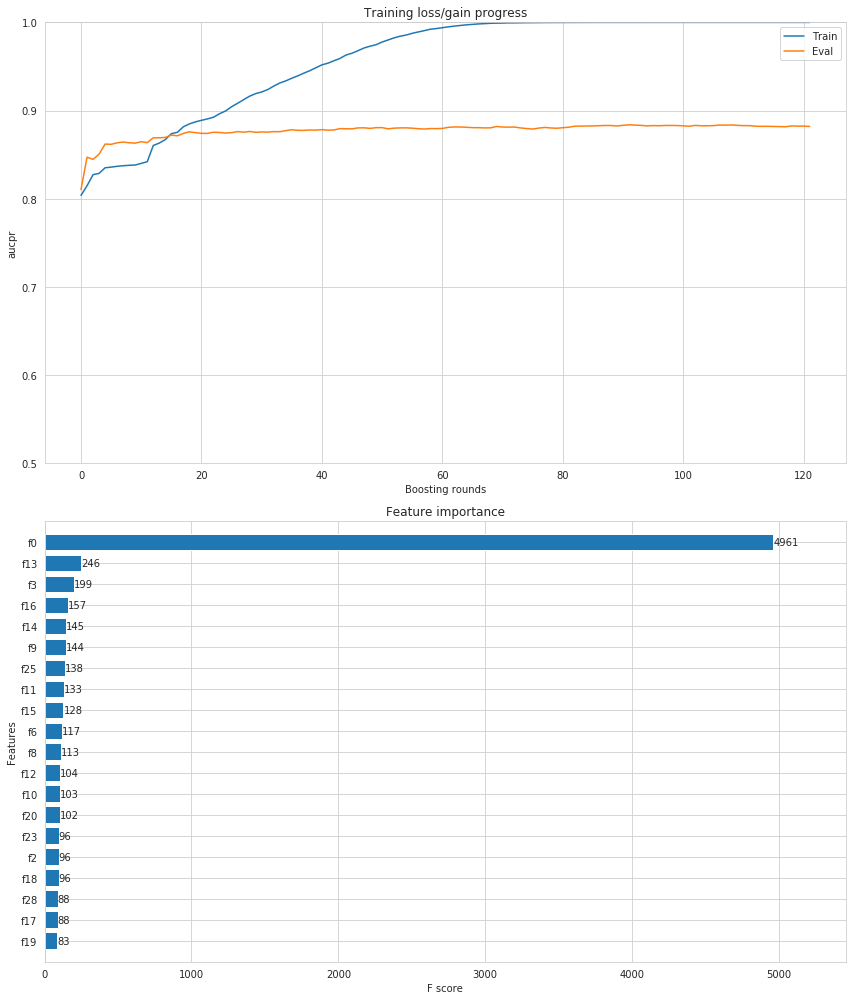

In [30]:
eval_tree(eval_loss, 'aucpr', xgbclf)

The model let 18 fraud cases go unalarmed and mistakes 10 cases as fraud. Overall a good baseline balance of precision and recall


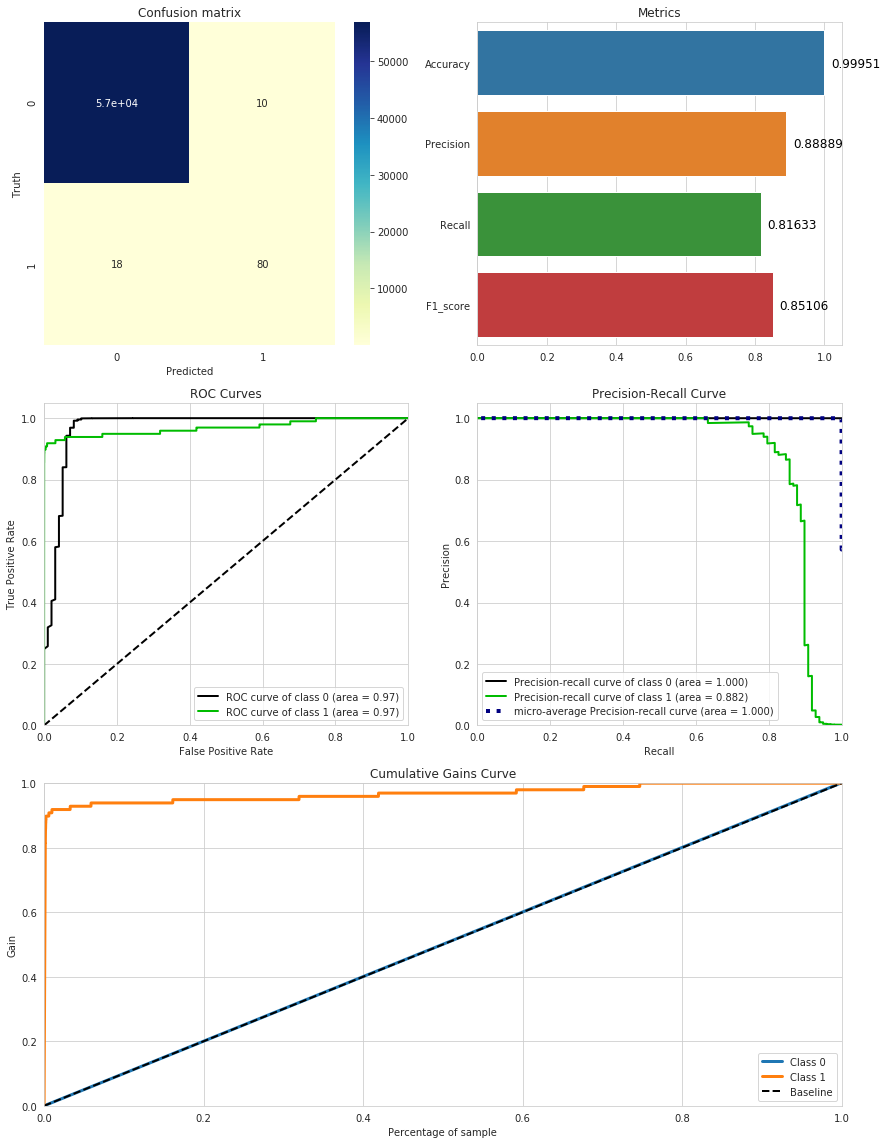

In [19]:
class_bin_eval(y_test, y_pred)

Let's look at shap values to see if feature over dependence holds true. 

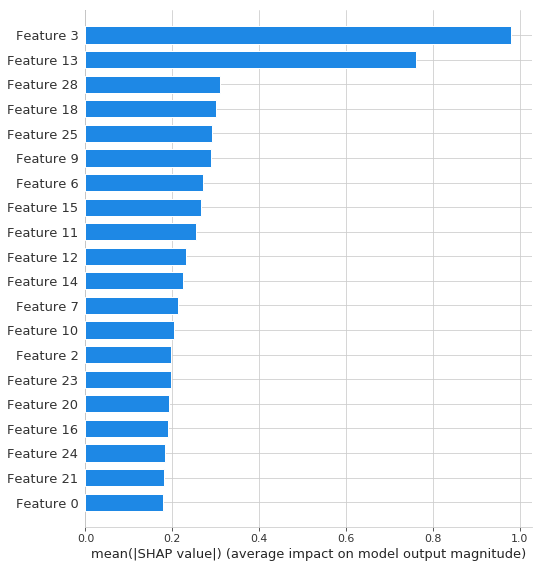

In [28]:
import shap

explainer = shap.TreeExplainer(xgbclf)
shap_val = explainer.shap_values(X_train, approximate=True)

shap.summary_plot(shap_val, X_train, plot_type='bar')

# Saving model

In [31]:
from sklearn.externals import joblib

file_name = 'model_aucpr87.joblib.dat'

joblib.dump(xgbclf, file_name)

['model_aucpr87.joblib.dat']